In [1]:
import os
import pyspark.mllib
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import pyspark

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from IPython.display import display, HTML

# get_ipython().magic(u'pylab inline')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
### Initialize streaming context
conf = SparkConf()\
                .setMaster("local[2]")\
                .setAppName("AutoRegression")\
                .set("spark.executor.memory", "2g")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

In [29]:
### Attached file auto_mpg_original.csv contains a set of data on automobile characteristics and fuel consumption.
### File auto_mpg_description.csv contains the description of the data.
### Import data into Spark.

path = "file:////Users/swaite/Stirling/CSIE-63/assignment-7/data/auto_mpg_original-1.csv"
df = sc.textFile(path, use_unicode=False) \
                    .map(lambda x: x.split(","))\
                    .map(lambda x: Row(
                        mpg=float(x[0].replace('NA', "0.0")),
                        cylinders=float(x[1].replace('NA', "0.0")),
                        displacement=float(x[2].replace('NA', "0.0")),
                        horsepower=float(x[3].replace('NA', "0.0")),
                        weight=float(x[4].replace('NA', "0.0")),
                        acceleration=float(x[5].replace('NA', "0.0")),
                        model_year=float(x[6].replace('NA', "0.0")),
                        origin=float(x[7].replace('NA', "0.0")),
                        car_name=str(x[8])
                    )) \
                    .filter(lambda x: x[0] > 0.0)\
                    .filter(lambda x: x[3] > 0.0)\
                    .toDF()
        
print(df.show(5))

+------------+---------+---------+------------+----------+----------+----+------+------+
|acceleration| car_name|cylinders|displacement|horsepower|model_year| mpg|origin|weight|
+------------+---------+---------+------------+----------+----------+----+------+------+
|        12.0|chevrolet|      8.0|       307.0|     130.0|      70.0|18.0|   1.0|3504.0|
|        11.5|    buick|      8.0|       350.0|     165.0|      70.0|15.0|   1.0|3693.0|
|        11.0| plymouth|      8.0|       318.0|     150.0|      70.0|18.0|   1.0|3436.0|
|        12.0|      amc|      8.0|       304.0|     150.0|      70.0|16.0|   1.0|3433.0|
|        10.5|     ford|      8.0|       302.0|     140.0|      70.0|17.0|   1.0|3449.0|
+------------+---------+---------+------------+----------+----------+----+------+------+
only showing top 5 rows

None


In [30]:
#Summary of Input Variable
df2 = df.select(df.horsepower.cast("float"), df.mpg.cast("float"))
print(df2.show(10))
df2.describe().show()
marvar = df2.collect()

+----------+----+
|horsepower| mpg|
+----------+----+
|     130.0|18.0|
|     165.0|15.0|
|     150.0|18.0|
|     150.0|16.0|
|     140.0|17.0|
|     198.0|15.0|
|     220.0|14.0|
|     215.0|14.0|
|     225.0|14.0|
|     190.0|15.0|
+----------+----+
only showing top 10 rows

None
+-------+------------------+------------------+
|summary|        horsepower|               mpg|
+-------+------------------+------------------+
|  count|               406|               406|
|   mean|104.57881773399015|23.435467978416405|
| stddev|38.956860529340645| 7.855637115477021|
|    min|               0.0|               0.0|
|    max|             230.0|              46.6|
+-------+------------------+------------------+



In [43]:
# Look at distribution of data
# %pylab inline

# targets = df2.select("horsepower").rdd.flatMap(lambda x: x).collect()
# hist(targets, bins=40, color="light_blue", normed=True)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(8,5)

In [21]:
# set up performance metrics functions 

def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [38]:
# target(label): horsepower
# feature: mpg
# LabeledPoint(target, feature)

transformed = df2.rdd.map(lambda r: LabeledPoint(r[0], r[1:]))
print(transformed.take(5))

training_data, testing_data = transformed.randomSplit([.8, .2], seed=1234)
training_data = training_data.cache()
testing_data = testing_data.cache()
print(training_data.count())
print("Sample label (horsepower): " + str(training_data.first().label))
print "Sample feature (mpg): " + str(training_data.first().features[0])
print("Sample labeled points: ", testing_data.take(5))

[LabeledPoint(130.0, [18.0]), LabeledPoint(165.0, [15.0]), LabeledPoint(150.0, [18.0]), LabeledPoint(150.0, [16.0]), LabeledPoint(140.0, [17.0])]
330
Sample label (horsepower): 130.0
Sample feature (mpg): 18.0
('Sample labeled points: ', [LabeledPoint(115.0, [26.0]), LabeledPoint(85.0, [21.0]), LabeledPoint(95.0, [25.0]), LabeledPoint(48.0, [15.0]), LabeledPoint(100.0, [18.0])])


In [44]:
# Training the Model
linear_model = LinearRegressionWithSGD.train(training_data, iterations=1000, step=.0001)

print "\n"
print "--------------"
print "Linear model parameters"
print "--------------"

print(linear_model)

print "\n"
print "--------------"
print "Predictions "
print "--------------"

true_vs_predicted = testing_data.map(lambda p: (p.label, linear_model.predict(p.features)))
print("Linear Model predictions: " + str(true_vs_predicted.take(5)))

print "\n"
print "--------------"
print "Model Metrics "
print "--------------"


#Gather Metrics
mse = true_vs_predicted.map(lambda (t,p): squared_error(t,p)).mean()
mae = true_vs_predicted.map(lambda (t,p): abs_error(t,p)).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda (t,p): squared_log_error(t,p)).mean())

print("Linear Model - Mean Squared Error: %2.4f" % mse)
print("Linear Model - Mean Absolute Error: %2.4f" % mae)
print("Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle)



--------------
Linear model parameters
--------------
(weights=[2.96970534459], intercept=0.0)


--------------
Predictions 
--------------
Linear Model predictions: [(115.0, 77.212338959343398), (85.0, 62.363812236392739), (95.0, 74.24263361475326), (48.0, 44.545580168851956), (100.0, 53.454696202622351)]


--------------
Model Metrics 
--------------
Linear Model - Mean Squared Error: 4130.7654
Linear Model - Mean Absolute Error: 50.8381
Linear Model - Root Mean Squared Log Error: 0.7434


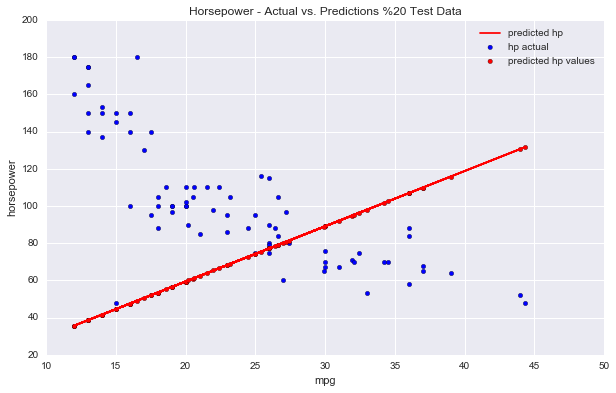

In [40]:
tvp = testing_data.map(lambda p: (float(p.label), float(linear_model.predict(p.features)), float(p.features[0]))).toDF().toPandas()
tvp.columns = ['horsepower', 'predicted_horsepower', 'mpg']

plt.figure(1, figsize = (10, 6))
plt.scatter(tvp["mpg"], tvp["horsepower"], c='b', label="hp actual")
plt.plot(tvp["mpg"], tvp["predicted_horsepower"], c='r', label="predicted hp")
plt.scatter(tvp["mpg"], tvp["predicted_horsepower"], c='r', label="predicted hp values")
plt.xlabel("mpg")
plt.ylabel("horsepower")
plt.title("Horsepower - Actual vs. Predictions %20 Test Data")
plt.legend()
plt.show()

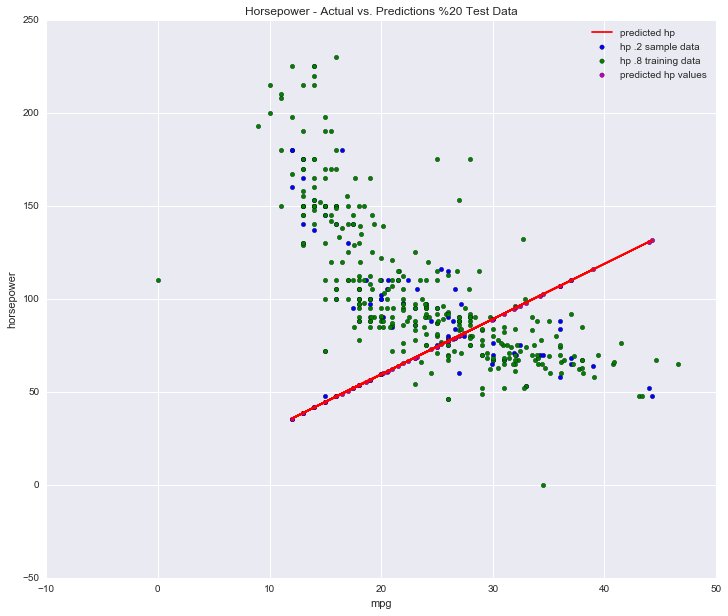

In [41]:
plt.figure(2, figsize = (12, 10))
tvp2 = training_data.map(lambda p: (float(p.label), float(linear_model.predict(p.features)), float(p.features[0]))).toDF().toPandas()
tvp2.columns = ['horsepower', 'predicted_horsepower', 'mpg']
plt.scatter(tvp["mpg"], tvp["horsepower"], c='b', label="hp .2 sample data")
plt.scatter(tvp2["mpg"], tvp2["horsepower"], c='g', label="hp .8 training data")
plt.plot(tvp["mpg"], tvp["predicted_horsepower"], c='r', label="predicted hp")
plt.scatter(tvp["mpg"], tvp["predicted_horsepower"], c='m', label="predicted hp values")
plt.xlabel("mpg")
plt.ylabel("horsepower")
plt.title("Horsepower - Actual vs. Predictions 20% Test Data")
plt.legend()
plt.show()